<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-&amp;-Inits" data-toc-modified-id="Imports-&amp;-Inits-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports &amp; Inits</a></span></li><li><span><a href="#Data-&amp;-Pretrained-Embeddings" data-toc-modified-id="Data-&amp;-Pretrained-Embeddings-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data &amp; Pretrained Embeddings</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Testing</a></span><ul class="toc-item"><li><span><a href="#Plots" data-toc-modified-id="Plots-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Plots</a></span></li><li><span><a href="#Ignite-Testing" data-toc-modified-id="Ignite-Testing-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Ignite Testing</a></span></li><li><span><a href="#NLPBook-Testing" data-toc-modified-id="NLPBook-Testing-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>NLPBook Testing</a></span></li></ul></li><li><span><a href="#Inference" data-toc-modified-id="Inference-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Inference</a></span></li><li><span><a href="#Going-through-the-model" data-toc-modified-id="Going-through-the-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Going through the model</a></span></li></ul></div>

# AG News Classifier with ConvNet
Classifier to classify news titles into categories.

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import pdb
import pandas as pd
import numpy as np
import torch
import re

from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader
from pathlib import Path

from ignite.engine import Events, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar

In [3]:
from consts import consts
from ag.data import NewsDataset, DataContainer
from ag.model import NewsClassifier, ModelContainer
from ag.pretrained_emb import PretrainedEmbeddings
from ag.trainer import IgniteTrainer
vars(consts)

{'path': PosixPath('../data/ag_news'),
 'work_dir': PosixPath('../data/ag_news/work_dir'),
 'proc_dataset_csv': PosixPath('../data/ag_news/news_with_splits.csv'),
 'model_dir': PosixPath('../data/ag_news/work_dir/models'),
 'vectorizer_file': PosixPath('../data/ag_news/work_dir/vectorizer.json'),
 'metrics_file': PosixPath('../data/ag_news/work_dir/metrics.csv'),
 'cw_file': PosixPath('../data/ag_news/work_dir/class_weights.pth'),
 'use_glove': False,
 'glove_path': PosixPath('../pretrained/glove6B/glove.6B.100d.txt'),
 'embedding_size': 100,
 'hidden_dim': 103,
 'n_channels': 101,
 'dropout_p': 0.1,
 'batch_size': 128,
 'learning_rate': 0.001,
 'num_epochs': 97,
 'device': 'cuda:3',
 'checkpointer_prefix': 'agnews',
 'checkpointer_name': 'classifier',
 'early_stopping_criteria': 11,
 'save_every': 2,
 'save_total': 5}

## Data & Pretrained Embeddings

In [4]:
df = pd.read_csv(consts.proc_dataset_csv)
df.head()

,category,split,title
0,Business,train,"Jobs, tax cuts key issues for Bush"
1,Business,train,Jarden Buying Mr. Coffee #39;s Maker
2,Business,train,Retail sales show festive fervour
3,Business,train,Intervoice's Customers Come Calling
4,Business,train,Boeing Expects Air Force Contract


In [5]:
dc = DataContainer(df, NewsDataset, consts.vectorizer_file, consts.batch_size, is_load=False)

try:
  class_weights = torch.load(consts.cw_file)
except FileNotFoundError:
  cat_vocab = dc.cat_vocab
  class_counts = df['category'].value_counts().to_dict()
  sorted_counts = sorted(class_counts.items(), key=lambda x: cat_vocab.lookup_token(x[0]))
  freq = [count for _, count in sorted_counts]
  class_weights = 1.0/torch.tensor(freq, dtype=torch.float32)
  torch.save(class_weights, consts.cw_file)  

Creating and saving vectorizer


In [6]:
pe = PretrainedEmbeddings.from_file(consts.glove_path)
pe.make_custom_embeddings(list(dc.title_vocab.idx_token_bidict.values()))

Loading pretrained embeddings...
Finished!


## Model

In [7]:
classifier = NewsClassifier(consts.embedding_size, dc.vocab_size, consts.n_channels, consts.hidden_dim,
                            dc.n_classes, consts.dropout_p)
optimizer = optim.Adam(classifier.parameters(), lr=consts.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, 1)

classifier_pretrained = NewsClassifier(consts.embedding_size, dc.vocab_size, consts.n_channels,
                                       consts.hidden_dim, dc.n_classes, consts.dropout_p,
                                       pretrained=pe.custom_embeddings)
optimizer_pretrained = optim.Adam(classifier_pretrained.parameters(), lr=consts.learning_rate)
scheduler_pretrained = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pretrained, 'min', 0.5, 1)

classifier_pretrained_freeze = NewsClassifier(consts.embedding_size, dc.vocab_size, consts.n_channels,
                                              consts.hidden_dim, dc.n_classes, consts.dropout_p,
                                              pretrained=pe.custom_embeddings, freeze_pretrained=True)
optimizer_pretrained_freeze = optim.Adam(classifier_pretrained_freeze.parameters(), lr=consts.learning_rate)
scheduler_pretrained_freeze = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pretrained_freeze, 'min', 0.5, 1)

classifiers = [classifier, classifier_pretrained, classifier_pretrained_freeze]
optimizers = [optimizer, optimizer_pretrained, optimizer_pretrained_freeze]
schedulers = [scheduler, scheduler_pretrained, scheduler_pretrained_freeze]

In [ ]:
class_weights = class_weights.to(consts.device)
class_weights

In [ ]:
loss_fn = nn.CrossEntropyLoss(class_weights)

In [ ]:
itr = iter(dc.train_dl)

In [ ]:
x,y = next(itr)
y_preds = [classifier(x) for classifier in classifiers]
losses = [loss_fn(y_pred,y) for y_pred in y_preds]
losses

In [ ]:
mcs = [ModelContainer(c, o, loss_fn, s) for c,o,s in zip(classifiers, optimizers, schedulers)]

In [ ]:
pbar = ProgressBar(persist=True)
metrics = {'accuracy': Accuracy(), 'loss': Loss(loss_fn)}

## Training

In [ ]:
consts.metric_file=consts.work_dir/'metrics.csv'
consts.num_epochs=2

In [ ]:
ig1 = IgniteTrainer(mcs[0], dc, consts, pbar, metrics)
ig1.run()

## Testing

In [8]:
VANILLA=0
PRETRAINED=1
FROZEN=2

In [9]:
loss_fn = nn.CrossEntropyLoss(class_weights)
pbar = ProgressBar(persist=True)
metrics = {'accuracy': Accuracy(), 'loss': Loss(loss_fn)}

In [10]:
state_dicts = [consts.work_dir/'agnews_vanilla.pth', consts.work_dir/'agnews_pretrained.pth',
               consts.work_dir/'agnews_frozen.pth']
metric_files = [consts.work_dir/'metrics_vanilla.csv', consts.work_dir/'metrics_pretrained.csv',
              consts.work_dir/'metrics_frozen.csv']
idx = PRETRAINED

### Plots

In [11]:
training_metrics = pd.read_csv(metric_files[idx])
training_metrics = training_metrics[:-1]

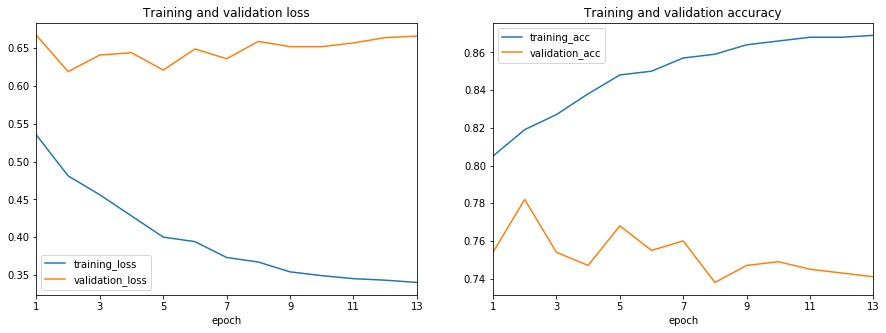

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
training_metrics.plot(x='epoch', y=['training_loss', 'validation_loss'], kind='line',
                      title='Training and validation loss', ax=axes[0])
training_metrics.plot(x='epoch', y=['training_acc', 'validation_acc'], kind='line',
                      title='Training and validation accuracy', ax=axes[1])

### Ignite Testing

In [13]:
classifier = classifiers[idx]
state_dict = torch.load(state_dicts[idx])
classifier.load_state_dict(state_dict)

evaluator = create_supervised_evaluator(classifier, metrics=metrics)

@evaluator.on(Events.COMPLETED)
def log_testing_results(engine):
  metrics = engine.state.metrics
  print(f"Test loss: {metrics['loss']:0.3f}")
  print(f"Test accuracy: {metrics['accuracy']:0.3f}")

evaluator.run(dc.test_dl)

Test loss: 0.591
Test accuracy: 0.797


### NLPBook Testing

In [14]:
def compute_accuracy(y_pred, y_target):
  _, y_pred_indices = y_pred.max(dim=1)
  n_correct = torch.eq(y_pred_indices, y_target).sum().item()
  return n_correct / len(y_pred_indices) * 100

running_loss = 0.
running_acc = 0.

classifier.eval()
for i, batch in enumerate(dc.test_dl):
  x,y = batch
  y_pred = classifier(x_in=x)
  
  loss = loss_fn(y_pred, y)
  loss_t = loss.item()
  running_loss += (loss_t-running_loss)/(i+1)
  
  acc_t = compute_accuracy(y_pred, y)
  running_acc += (acc_t-running_acc)/(i+1)

print(f"Test loss: {running_loss:0.3f}")
print(f"Test acc: {running_acc:0.3f}%")

Test loss: 0.593
Test acc: 79.688%


## Inference

In [15]:
# Preprocess the reviews
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [16]:
def predict_category(title, classifer, vectorizer, max_length):
  """
    Predict a News category for a new title

    Args:
      title (str): a raw title string
      classifier (NewsClassifier): an instance of the trained classifier
      vectorizer (NewsVectorizer): the corresponding vectorizer
      max_length (int): the max sequence length
          Note: CNNs are sensitive to the input data tensor size. 
                This ensures to keep it the same size as the training data
  """
  title = preprocess_text(title)
  vectorized_title = torch.tensor(vectorizer.vectorize(title, max_length))
  
  # add batch dim so you have a batch of size 1
  result = classifier(vectorized_title.unsqueeze(0), apply_softmax=True)
  prob_vals, idxs = result.max(dim=1)
  pred_cat = vectorizer.category_vocab.lookup_idx(idxs.item())
  
  return {'category': pred_cat, 'prob': prob_vals.item()}

In [17]:
def get_samples():
  samples = {}
  for cat in dc._val_df['category'].unique():
    samples[cat] = dc._val_df['title'][dc._val_df['category'] == cat].tolist()[:5]
  return samples

samples = get_samples()

In [18]:
for truth, sample_group in samples.items():
  print(f"True Category {truth}")
  print("="*30)
  for sample in sample_group:
    pred = predict_category(sample, classifier, dc.vectorizer, dc._train_ds.max_seq_length+2)
    print(f"Prediction: {pred['category']} (p={pred['prob']:0.2f})")
    print(f"\t + Sample: {sample}")
  print("-"*30 + "\n")

True Category Business
Prediction: Business (p=0.53)
	 + Sample: AZ suspends marketing of cancer drug
Prediction: Business (p=0.91)
	 + Sample: Business world has mixed reaction to Perez move
Prediction: Sports (p=0.57)
	 + Sample: Betting Against Bombay
Prediction: Sports (p=0.45)
	 + Sample: Malpractice Insurers Face a Tough Market
Prediction: Sports (p=0.54)
	 + Sample: NVIDIA Is Vindicated
------------------------------

True Category Sci/Tech
Prediction: Business (p=0.38)
	 + Sample: Spies prize webcam #39;s eyes
Prediction: Sci/Tech (p=0.56)
	 + Sample: Sober worm causes headaches
Prediction: Sports (p=0.38)
	 + Sample: Local Search: Missing Pieces Falling into Place
Prediction: Sci/Tech (p=0.88)
	 + Sample: Hackers baiting Internet users with Beckham pix
Prediction: Sports (p=0.97)
	 + Sample: Nokia adds BlackBerry support to Series 80 handsets
------------------------------

True Category Sports
Prediction: Sports (p=0.34)
	 + Sample: Is Meyer the man to get Irish up?
Predictio

## Going through the model

In [ ]:
emb = nn.Embedding(dc.vocab_size, consts.embedding_size)
conv1s = nn.Sequential(
      nn.Conv1d(in_channels=consts.embedding_size, out_channels=consts.n_channels, kernel_size=3, padding=1),
      nn.ELU())
conv2s = nn.Sequential(nn.Conv1d(in_channels=consts.n_channels, out_channels=consts.n_channels,
         kernel_size=3, stride=2), nn.ELU())
dropout = nn.Dropout(p=consts.dropout_p)
relu = nn.ReLU()
fc1 = nn.Linear(in_features=consts.n_channels, out_features=consts.hidden_dim)
fc2 = nn.Linear(in_features=consts.hidden_dim, out_features=dc.n_cats)
softmax = nn.Softmax(dim=1)

In [ ]:
itr = iter(dc.train_dl)

In [ ]:
x,y = next(itr)
print(x.shape, y.shape)

In [ ]:
print(emb)
t = emb(x)
print(t.shape)
t = t.permute(0,2,1)
print(t.shape)

In [ ]:
print(conv1s)
t = conv1s(t)
print(t.shape)

In [ ]:
print(conv2s)
t = conv2s(t)
print(t.shape)

In [ ]:
print(conv2s)
t = conv2s(t)
print(t.shape)

In [ ]:
print(conv1s)
t = conv1s(t)
print(t.shape)

In [ ]:
p = F.avg_pool1d(t, 3)
print(p.shape)
torch.all(p==t)

In [ ]:
p = p.squeeze(dim=2)
print(p.shape)

In [ ]:
print(fc1)
p = fc1(p)
p = dropout(p)
print(p.shape)

In [ ]:
print(fc2)
p = fc2(p)
print(p.shape)